# Regression problem with `numpyro`

## Import packages

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting

import jax
import jax.numpy as jnp
import numpyro #package qui permet d'utiliser mcmc 
from numpyro import distributions as dist, infer
from jax import jit  # Ensure JIT is imported

numpyro.set_host_device_count(4)
jax.config.update("jax_enable_x64", True)

## Create the fake linear dataset

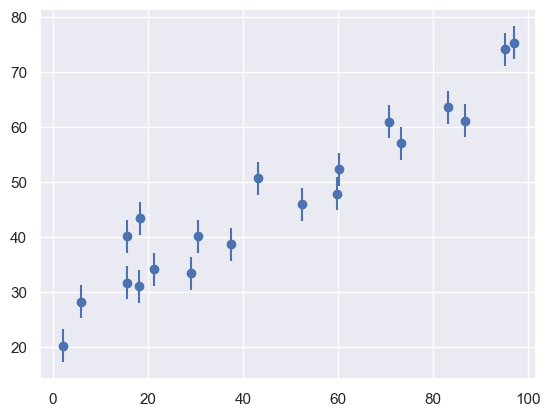

In [43]:
# Making the data
def make_data(intercept, slope, N=20, dy=5, rseed=42): #we feed it the correct a, b and imitate noise
    rand = np.random.RandomState(rseed) #have all codes look the same
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N) #add noise to imitate irl
    return x, y, dy * np.ones_like(x) - 2.0 # Reducing the error bars to see if wn model can fit the data

theta_true = [25, 0.5]
x, y, dy = make_data(*theta_true)
x, y, dy = jnp.array(x), jnp.array(y), jnp.array(dy)
plt.errorbar(x, y, dy, fmt='o');

## Create the model and jax model

In [48]:
@jit 
def model(theta, x):
    return theta[0] * jnp.sin(theta[1] * x + theta[2]) + theta[3] * x + theta[4] 

def jax_model(x, y=None, dy=None):
    # Paramter a 
    a = numpyro.sample('a', dist.Uniform(0, 10))
    
    # Parameter b
    w = numpyro.sample('w', dist.Uniform(1e-5, 100))

    # Paramter a 
    phi = numpyro.sample('phi', dist.Uniform(0, 2*np.pi))
    
    # Parameter b
    m = numpyro.sample('m', dist.Uniform(-10, 10))

    # Paramter a 
    c = numpyro.sample('c', dist.Uniform(-50, 50))
    
    # Define parameter vector
    theta = [a, w, phi, m, c]
    
    # Define white noise model
    wn = numpyro.sample('wn', dist.LogUniform(0.01, 10.0)) 
    #The noise we are adding it is bigger than 0.01 but smaller than 10, 
    #LogUniform: the probability between different orders to be the same. 
    #Ex. the uncertainty will be closer to 0.01-1 -> will explore smaller values first 
    
    # Expected value
    y_pred = model(theta, x)
    
    noise = jnp.sqrt(dy**2 + wn**2)
    numpyro.sample('y', dist.Normal(y_pred, noise), obs=y)

## Run the MCMC

In [49]:
# Define the number of warm-up steps, samples, and chains
ndim = 6
num_warmup = ndim * 100
num_samples = ndim * 1000
num_chains = 2

# Use NUTS sampler with initialization strategy set to predefined values
nuts_model = infer.NUTS(jax_model)
sampler = infer.MCMC(
    nuts_model,  # Initialize with the defined initial values
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=True,
)

# Ensure random seed is provided and compatible with JAX
seed = jax.random.PRNGKey(6)

# Run the sampler on the model with time and observed RV data
sampler.run(seed, x, y, dy)

# Summarize the results
sampler.print_summary()


  0%|          | 0/6600 [00:00<?, ?it/s]

  0%|          | 0/6600 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.24      1.69      3.35      0.16      5.51      3.36      1.20
         c     24.48      1.84     24.45     21.52     27.55     35.91      1.06
         m      0.48      0.03      0.48      0.43      0.53     51.29      1.02
       phi      3.26      1.60      3.51      0.31      5.44     35.18      1.19
         w     46.68     22.22     48.22      0.07     70.95      7.12      1.52
        wn      2.19      1.72      2.18      0.01      4.11      2.09      1.37

Number of divergences: 51


In [50]:
samples = sampler.get_samples()
best_params = {k: jnp.median(v) for k, v in samples.items()}
print(best_params)

{'a': Array(3.3519458, dtype=float64), 'c': Array(24.44677071, dtype=float64), 'm': Array(0.48085089, dtype=float64), 'phi': Array(3.50864563, dtype=float64), 'w': Array(48.21845161, dtype=float64), 'wn': Array(2.18313484, dtype=float64)}


## Cornerplot

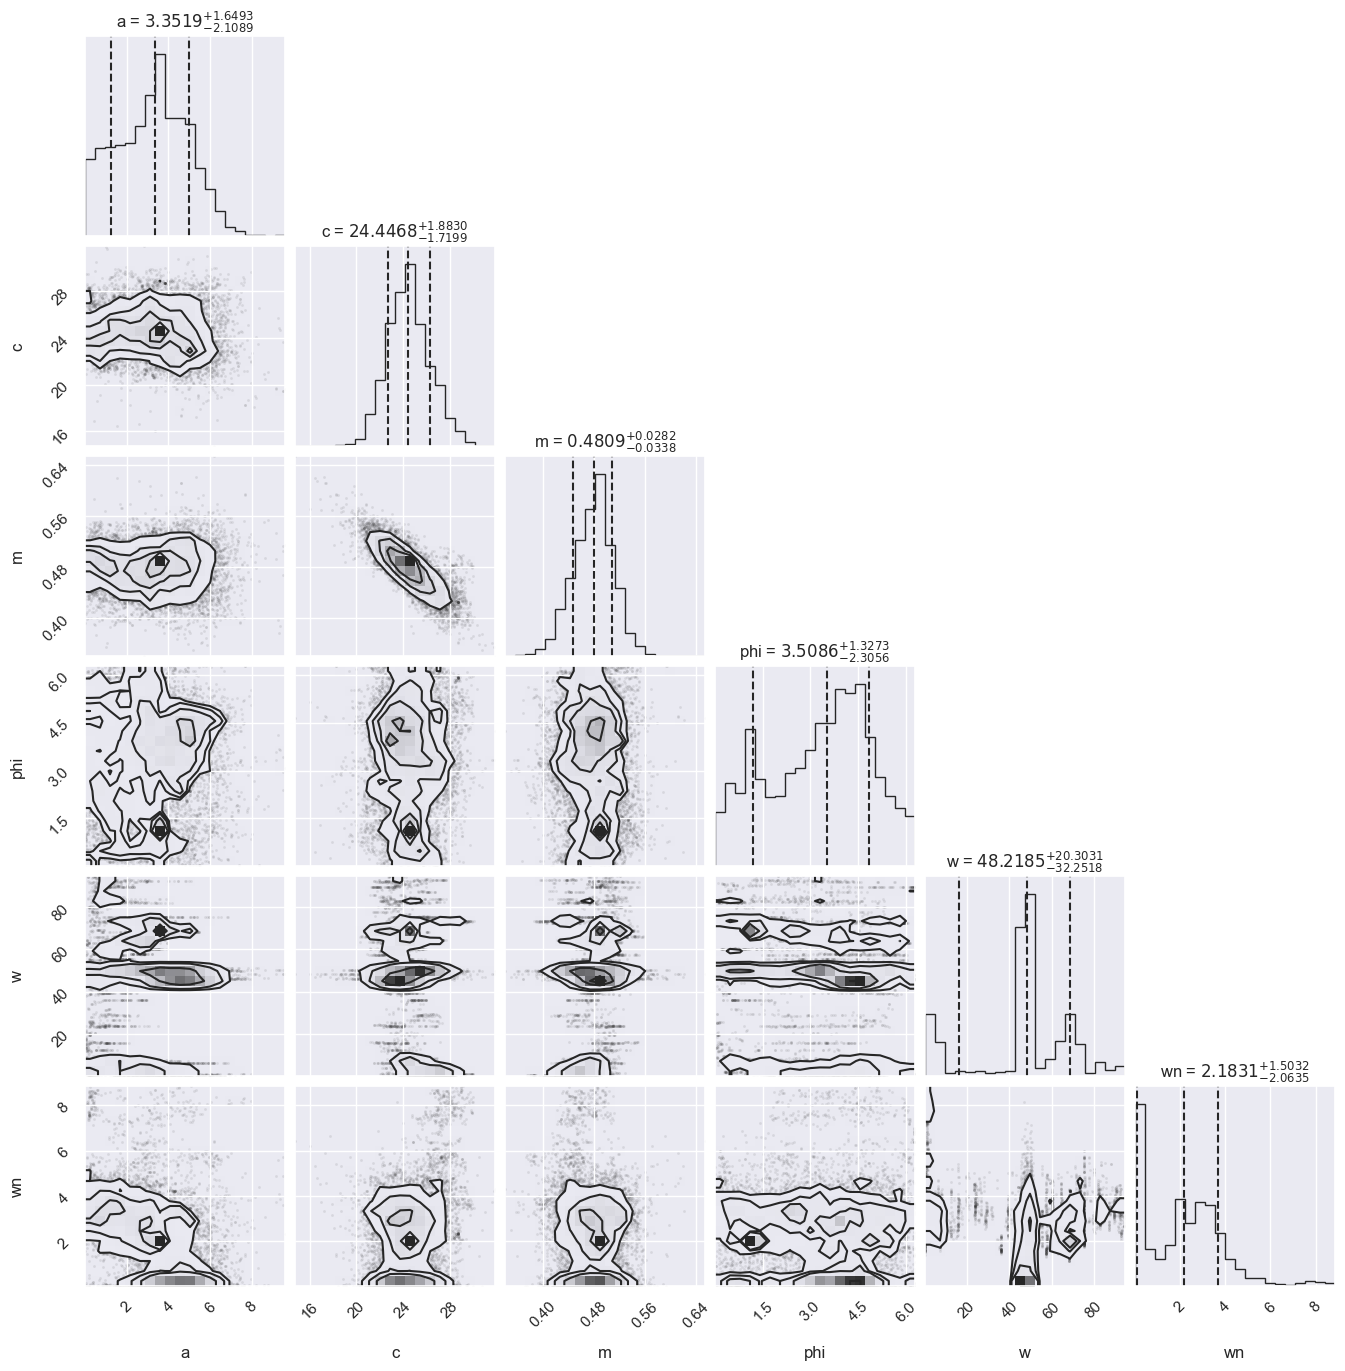

In [51]:
import corner
import arviz

_ = corner.corner(
    samples,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
)

## Best-fit

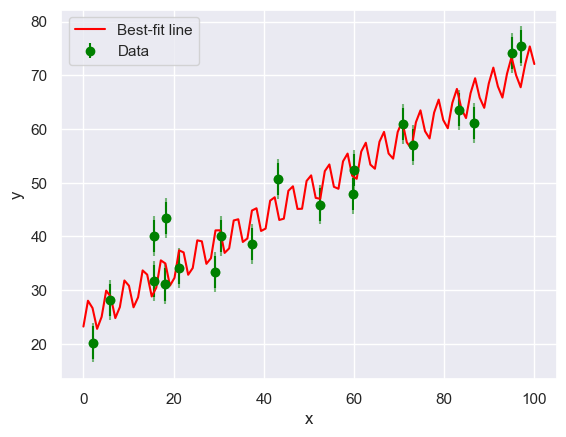

In [53]:
# Extract best-fit parameters
a_best = best_params['a']
w_best = best_params['w']
phi_best = best_params['phi']
m_best = best_params['m']
c_best = best_params['c']
wn_best = best_params['wn']

# Generate best-fit line
x_fit = jnp.linspace(0, 100, 100)
y_fit = model([a_best, w_best, phi_best, m_best, c_best], x_fit)

# Plot the data points with regular error bars
plt.errorbar(x, y, dy, fmt='o', label='Data', color='green')

# Plot the data points with white noise model error bars
plt.errorbar(x, y, np.sqrt(dy**2 + wn_best**2), fmt='o', color='green', alpha = 0.5)

# Plot the best-fit line
plt.plot(x_fit, y_fit, label='Best-fit line', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()